# SLEAP Distance Calculation

Brief 1-2 sentence description of notebook.

In [1]:
import os
import glob
import git


In [2]:
# Imports of all used packages and libraries
import numpy as np
import pandas as pd
# import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import h5py
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter


In [3]:
git_repo = git.Repo(".", search_parent_directories=True)
git_root = git_repo.git.rev_parse("--show-toplevel")

In [4]:
git_root

'/nancy/projects/nose_poke_identifier'

In [5]:
# sns.set('notebook', 'ticks', font_scale=1.2)
mpl.rcParams['figure.figsize'] = [15,6]

## Inputs & Data

Explanation of each input and where it comes from.

In [6]:
# Inputs and Required data loading
# input varaible names are in all caps snake case
# Whenever an input changes or is used for processing 
# the vairables are all lower in snake case
THORAX_INDEX = 1
# TONE_TIMESTAMP_DF = pd.read_csv("./proc/rce_tone_timestamp.csv", index_col=0)
# VIDEO_TO_FRAME_AND_SUBJECT_DF = pd.read_excel("../../proc/video_to_frame_and_subject.xlsx")
VIDEO_TO_FRAME_AND_SUBJECT_DF = pd.read_pickle(os.path.join(git_root, "proc/rce_pilot_2_trodes_metadata.pkl"))
# Remove the .videoTimeStamps.cameraHWSync from the video name
VIDEO_TO_FRAME_AND_SUBJECT_DF["video_name"] = VIDEO_TO_FRAME_AND_SUBJECT_DF["video_name"].apply(lambda x: x.strip(".videoTimeStamps.cameraHWSync")).iloc[0]

SLEAP_DIR = os.path.join(git_root, "proc/sleap") 

OUTPUT_DIR = r"./proc" # where data is saved should always be shown in the inputs
MED_PC_WIDTH = 29.5
MED_PC_HEIGHT = 24
FRAME_RATE = 22
WINDOW_SIZE = 25
DISTANCE_THRESHOLD = 2

In [7]:
VIDEO_TO_FRAME_AND_SUBJECT_DF

,session_dir,video_name,session_path,tone_frames,port_entry_frames,recording,current_subject
0,20230612_112630_standard_comp_to_training_D1_s...,20230612_112630_standard_comp_to_training_D1_s...,/nancy/projects/nose_poke_identifier/data/2023...,"[[1125, 1324], [3519, 3720], [5815, 6014], [76...","[[192, 248], [389, 405], [916, 929], [929, 948...",[20230612_112630_standard_comp_to_training_D1_...,"[1.1, 1.2]"


## Outputs

Describe each output that the notebook creates. 

- Is it a plot or is it data?

- How valuable is the output and why is it valuable or useful?

## Processing

Describe what is done to the data here and how inputs are manipulated to generate outputs. 

In [8]:
def get_sleap_tracks_from_h5(filename):
    """
    Retrieve pose tracking data (tracks) from a SLEAP-generated h5 file.
    
    This function is intended for use with Pandas' apply method on columns containing filenames.
    
    Parameters:
    ----------
    filename : str
        Path to the SLEAP h5 file containing pose tracking data.
        
    Returns:
    -------
    np.ndarray
        A transposed version of the 'tracks' dataset in the provided h5 file.
        
    Example:
    --------
    df['tracks'] = df['filename_column'].apply(get_sleap_tracks_from_h5)
    
    """
    with h5py.File(filename, "r") as f:
        return f["tracks"][:].T

In [9]:
def get_sleap_track_names_from_h5(filename):
    """
    Retrieve the names of tracked features from a SLEAP-generated h5 file.
    
    This function is intended for use with Pandas' apply method on columns containing filenames.
    
    Parameters:
    ----------
    filename : str
        Path to the SLEAP h5 file containing pose tracking data.
        
    Returns:
    -------
    h5py.Dataset
        The 'track_names' dataset in the provided h5 file, representing the names of the tracked features.
        
    Example:
    --------
    df['track_names'] = df['filename_column'].apply(get_sleap_track_names_from_h5)
    
    """
    with h5py.File(filename, "r") as f:
        return [item.tobytes().decode('utf-8') for item in f["track_names"][:]]


In [10]:
def get_node_names_from_sleap(filename):
    """
    Retrieve node names from a SLEAP h5 file.

    Parameters:
    - filename (str): Path to the SLEAP h5 file.

    Returns:
    - list of str: List of node names.
    """
    with h5py.File(filename, "r") as f:
        return [n.decode() for n in f["node_names"][:]]

In [11]:

def fill_missing(Y, kind="linear"):
    """Fills missing values independently along each dimension after the first."""

    # Store initial shape.
    initial_shape = Y.shape

    # Flatten after first dim.
    Y = Y.reshape((initial_shape[0], -1))

    # Interpolate along each slice.
    for i in range(Y.shape[-1]):
        y = Y[:, i]

        # Build interpolant.
        x = np.flatnonzero(~np.isnan(y))
        f = interp1d(x, y[x], kind=kind, fill_value=np.nan, bounds_error=False)

        # Fill missing
        xq = np.flatnonzero(np.isnan(y))
        y[xq] = f(xq)
        
        # Fill leading or trailing NaNs with the nearest non-NaN values
        mask = np.isnan(y)
        y[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), y[~mask])

        # Save slice
        Y[:, i] = y

    # Restore to initial shape.
    Y = Y.reshape(initial_shape)

    return Y

In [12]:
def compute_velocity(node_loc, window_size=25, polynomial_order=3):
    """
    Calculate the velocity of tracked nodes from pose data.
    
    The function utilizes the Savitzky-Golay filter to smooth the data and compute the velocity.
    
    Parameters:
    ----------
    node_loc : numpy.ndarray
        The location of nodes, represented as an array of shape [frames, 2]. 
        Each row represents x and y coordinates for a particular frame.
        
    window_size : int, optional
        The size of the window used for the Savitzky-Golay filter. 
        Represents the number of consecutive data points used when smoothing the data.
        Default is 25.
        
    polynomial_order : int, optional
        The order of the polynomial fit to the data within the Savitzky-Golay filter window.
        Default is 3.

    Returns:
    -------
    numpy.ndarray
        The velocity for each frame, calculated from the smoothed x and y coordinates.
    
    """
    node_loc_vel = np.zeros_like(node_loc)
    
    # For each coordinate (x and y), smooth the data and calculate the derivative (velocity)
    for c in range(node_loc.shape[-1]):
        node_loc_vel[:, c] = savgol_filter(node_loc[:, c], window_size, polynomial_order, deriv=1)
    
    # Calculate the magnitude of the velocity vectors for each frame
    node_vel = np.linalg.norm(node_loc_vel, axis=1)

    return node_vel

In [13]:
def extract_sleap_data(filename):
    """
    Extracts coordinates, names of body parts, and track names from a SLEAP file.
    
    Parameters:
    - filename (str): Path to the SLEAP file.
    
    Returns:
    - tuple: A tuple containing the following elements:
        * locations (numpy.ndarray): Array containing the coordinates.
        * node_names (list of str): List of body part names.
        * track_names (list of str): List of track names.
    
    Example:
    >>> locations, node_names, track_names = extract_sleap_data("path/to/sleap/file.h5")
    """
    result = {}
    with h5py.File(filename, "r") as f:
        result["locations"] = f["tracks"][:].T
        result["node_names"] = [n.decode() for n in f["node_names"][:]]
        result["track_names"] = [n.decode() for n in f["track_names"][:]]

    return result

In [14]:
def rescale_dimension_in_array(arr, dimension=0, ratio=1):
    """
    Rescale values of a specified dimension in a 3D numpy array for the entire array.
    
    Parameters:
    - arr (numpy.ndarray): A 3D numpy array where the third dimension is being rescaled.
    - dimension (int, default=0): Specifies which dimension (0 or 1) of the third 
                                  dimension in the array should be rescaled. 
                                  For instance, in many contexts:
                                  0 represents the x-coordinate, 
                                  1 represents the y-coordinate.
    - ratio (float, default=1): The scaling factor to be applied.
    
    Returns:
    - numpy.ndarray: The rescaled array.
    """
    
    arr[:,:,dimension] *= ratio
    return arr

In [15]:
def slice_and_zero(arr, frame_start, frame_end):
    # Create an array of zeros with the same shape as the input array
    result = np.zeros_like(arr)
    
    # Update the zeros array with the values from the input array slice
    result[frame_start:frame_end] = arr[frame_start:frame_end]
    
    return result

# Reading in the h5 files between recordings

In [16]:
VIDEO_TO_FRAME_AND_SUBJECT_DF.head()

,session_dir,video_name,session_path,tone_frames,port_entry_frames,recording,current_subject
0,20230612_112630_standard_comp_to_training_D1_s...,20230612_112630_standard_comp_to_training_D1_s...,/nancy/projects/nose_poke_identifier/data/2023...,"[[1125, 1324], [3519, 3720], [5815, 6014], [76...","[[192, 248], [389, 405], [916, 929], [929, 948...",[20230612_112630_standard_comp_to_training_D1_...,"[1.1, 1.2]"


In [17]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["video_name"].iloc[0]

'20230612_112630_standard_comp_to_training_D1_subj_1-2_and_1-1.1'

In [18]:
# VIDEO_TO_FRAME_AND_SUBJECT_DF["video_path"] = VIDEO_TO_FRAME_AND_SUBJECT_DF["video_name"].apply(lambda x: os.path.join(SLEAP_DIR, "*", x + "*.h5"))
VIDEO_TO_FRAME_AND_SUBJECT_DF["sleap_glob"] = VIDEO_TO_FRAME_AND_SUBJECT_DF["video_name"].apply(lambda x: glob.glob(os.path.join(SLEAP_DIR, "*", x + "*2_subj*.h5")))
VIDEO_TO_FRAME_AND_SUBJECT_DF["sleap_path"] = VIDEO_TO_FRAME_AND_SUBJECT_DF["sleap_glob"].apply(lambda x: x[0])

In [19]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["sleap_path"].iloc[0]

'/nancy/projects/nose_poke_identifier/proc/sleap/20230612_112630_standard_comp_to_training_D1_subj_1-2_and_1-1/20230612_112630_standard_comp_to_training_D1_subj_1-2_and_1-1.1.fixed.2_subj.round_1.id_corrected.h5'

In [20]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["all_sleap_data"] = VIDEO_TO_FRAME_AND_SUBJECT_DF["sleap_path"].apply(lambda x: extract_sleap_data(x))


In [21]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["locations"] = VIDEO_TO_FRAME_AND_SUBJECT_DF["all_sleap_data"].apply(lambda x: x["locations"])

In [22]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["track_names"] = VIDEO_TO_FRAME_AND_SUBJECT_DF["all_sleap_data"].apply(lambda x: x["track_names"])

In [23]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["track_names"]

0    [1.1, 1.2]
Name: track_names, dtype: object

In [24]:
# Getting the coordinates of all the body parts for all the animals for the entire recording
VIDEO_TO_FRAME_AND_SUBJECT_DF["locations"] = VIDEO_TO_FRAME_AND_SUBJECT_DF["sleap_path"].apply(lambda x: get_sleap_tracks_from_h5(x))
# Getting the name of the tracks which correspond to the animal id
VIDEO_TO_FRAME_AND_SUBJECT_DF["track_names"] = VIDEO_TO_FRAME_AND_SUBJECT_DF["sleap_path"].apply(lambda x: get_sleap_track_names_from_h5(x))

In [25]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["locations"].iloc[0].shape

(68258, 6, 2, 2)

In [26]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["track_names"].iloc[0]

['1.1', '1.2']

In [27]:
# Getting the indexes of each subject from the track list
VIDEO_TO_FRAME_AND_SUBJECT_DF["subject_to_index"] = VIDEO_TO_FRAME_AND_SUBJECT_DF.apply(lambda x: {k: x["track_names"].index(k) for k in x["current_subject"]}, axis=1)

In [28]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["subject_to_index"]

0    {'1.1': 0, '1.2': 1}
Name: subject_to_index, dtype: object

In [29]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["subject_to_tracks"] = VIDEO_TO_FRAME_AND_SUBJECT_DF.apply(lambda x: {k:v for k, v in x["subject_to_index"].items()}, axis=1)

In [30]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["subject_to_tracks"]

0    {'1.1': 0, '1.2': 1}
Name: subject_to_tracks, dtype: object

In [31]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["subject_to_tracks"] = VIDEO_TO_FRAME_AND_SUBJECT_DF.apply(lambda x: {k: x["locations"][:,:,:,v] for k, v in x["subject_to_index"].items()}, axis=1)

In [32]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["subject_to_tracks"]

0    {'1.1': [[[331.99508667 127.74658203], [307.31...
Name: subject_to_tracks, dtype: object

In [33]:
VIDEO_TO_FRAME_AND_SUBJECT_DF.head()

,session_dir,video_name,session_path,tone_frames,port_entry_frames,recording,current_subject,sleap_glob,sleap_path,all_sleap_data,locations,track_names,subject_to_index,subject_to_tracks
0,20230612_112630_standard_comp_to_training_D1_s...,20230612_112630_standard_comp_to_training_D1_s...,/nancy/projects/nose_poke_identifier/data/2023...,"[[1125, 1324], [3519, 3720], [5815, 6014], [76...","[[192, 248], [389, 405], [916, 929], [929, 948...",[20230612_112630_standard_comp_to_training_D1_...,"[1.1, 1.2]",[/nancy/projects/nose_poke_identifier/proc/sle...,/nancy/projects/nose_poke_identifier/proc/slea...,{'locations': [[[[331.99508667 244.3555603 ] ...,"[[[[331.99508667 244.3555603 ], [127.74658203 ...","[1.1, 1.2]","{'1.1': 0, '1.2': 1}","{'1.1': [[[331.99508667 127.74658203], [307.31..."


## Getting the coordinates of the corners

In [34]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["sleap_path"].iloc[0]

'/nancy/projects/nose_poke_identifier/proc/sleap/20230612_112630_standard_comp_to_training_D1_subj_1-2_and_1-1/20230612_112630_standard_comp_to_training_D1_subj_1-2_and_1-1.1.fixed.2_subj.round_1.id_corrected.h5'

In [35]:
# Each corner file is the in the same folder and has the same basename of the pose tracking file 
VIDEO_TO_FRAME_AND_SUBJECT_DF["corner_path"] = VIDEO_TO_FRAME_AND_SUBJECT_DF["sleap_path"].apply(lambda x: "{}.fixed.corner.h5".format(x.split("fixed")[0].strip(".")))

In [36]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["corner_path"].iloc[0]

'/nancy/projects/nose_poke_identifier/proc/sleap/20230612_112630_standard_comp_to_training_D1_subj_1-2_and_1-1/20230612_112630_standard_comp_to_training_D1_subj_1-2_and_1-1.1.fixed.corner.h5'

In [37]:
# Getting the indexes of each corner location
VIDEO_TO_FRAME_AND_SUBJECT_DF["corner_parts"] = VIDEO_TO_FRAME_AND_SUBJECT_DF["corner_path"].apply(lambda x: get_node_names_from_sleap(x))

In [38]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["corner_parts"]

0    [box_top_left, box_top_right, reward_port, box...
Name: corner_parts, dtype: object

In [39]:
# Getting the coordinates of all the corners
VIDEO_TO_FRAME_AND_SUBJECT_DF["corner_to_coordinate"] = VIDEO_TO_FRAME_AND_SUBJECT_DF["corner_path"].apply(lambda x: get_sleap_tracks_from_h5(x))

In [40]:
# Parsing out each corner and creating a dictionary of name to coordinates
VIDEO_TO_FRAME_AND_SUBJECT_DF["corner_to_coordinate"] = VIDEO_TO_FRAME_AND_SUBJECT_DF.apply(lambda x: {part: x["corner_to_coordinate"][:,index,:,:] for index, part in enumerate(x["corner_parts"])}, axis=1)

In [41]:
# Filtering out all the Nans because there's only one labeled frame
VIDEO_TO_FRAME_AND_SUBJECT_DF["corner_to_coordinate"] = VIDEO_TO_FRAME_AND_SUBJECT_DF.apply(lambda x: {k: v[~np.isnan(v)] for k, v in x["corner_to_coordinate"].items()}, axis=1)

In [42]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["corner_to_coordinate"]

0    {'box_top_left': [216.70920420006198, 380.5303...
Name: corner_to_coordinate, dtype: object

# Getting the distances between corners

- Getting the average width and height so that we can convert pixels to cm

In [43]:
# Using the x-coordinates for the width
VIDEO_TO_FRAME_AND_SUBJECT_DF["bottom_width"] = VIDEO_TO_FRAME_AND_SUBJECT_DF["corner_to_coordinate"].apply(lambda x: x["box_bottom_right"][0] - x["box_bottom_left"][0])
VIDEO_TO_FRAME_AND_SUBJECT_DF["top_width"] = VIDEO_TO_FRAME_AND_SUBJECT_DF["corner_to_coordinate"].apply(lambda x: x["box_top_right"][0] - x["box_top_left"][0])


In [44]:
# Using the y-coordinates for the height
VIDEO_TO_FRAME_AND_SUBJECT_DF["right_height"] = VIDEO_TO_FRAME_AND_SUBJECT_DF["corner_to_coordinate"].apply(lambda x: x["box_bottom_right"][1] - x["box_top_right"][1])
VIDEO_TO_FRAME_AND_SUBJECT_DF["left_height"] = VIDEO_TO_FRAME_AND_SUBJECT_DF["corner_to_coordinate"].apply(lambda x: x["box_bottom_left"][1] - x["box_top_left"][1])


In [45]:
# averaging the width and height by adding both sides and then getting the mean
VIDEO_TO_FRAME_AND_SUBJECT_DF["average_height"] = VIDEO_TO_FRAME_AND_SUBJECT_DF.apply(lambda row: (row["right_height"] + row["left_height"])/2, axis=1)
VIDEO_TO_FRAME_AND_SUBJECT_DF["average_width"] = VIDEO_TO_FRAME_AND_SUBJECT_DF.apply(lambda row: (row["bottom_width"] + row["top_width"])/2, axis=1)

- Getthing the pixel to cm ratio

In [46]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["width_ratio"] = MED_PC_WIDTH / VIDEO_TO_FRAME_AND_SUBJECT_DF["average_width"]
VIDEO_TO_FRAME_AND_SUBJECT_DF["height_ratio"] = MED_PC_HEIGHT / VIDEO_TO_FRAME_AND_SUBJECT_DF["average_height"]

In [47]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["height_ratio"]

0   -34.400226
Name: height_ratio, dtype: float64

In [48]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["width_ratio"]

0    0.139736
Name: width_ratio, dtype: float64

## Converting Pixels to cm

- Converting the X-dimension

In [49]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["subject_to_tracks"]

0    {'1.1': [[[331.99508667 127.74658203], [307.31...
Name: subject_to_tracks, dtype: object

In [50]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["rescaled_locations"] = VIDEO_TO_FRAME_AND_SUBJECT_DF.apply(lambda x: {key: rescale_dimension_in_array(value, dimension=0, ratio=x["width_ratio"]) for key, value in x["subject_to_tracks"].items()}, axis=1)

- Converting the Y-dimension

In [51]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["rescaled_locations"] = VIDEO_TO_FRAME_AND_SUBJECT_DF.apply(lambda x: {key: rescale_dimension_in_array(value, dimension=0, ratio=x["height_ratio"]) for key, value in x["subject_to_tracks"].items()}, axis=1)

In [52]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["corner_to_coordinate"]

0    {'box_top_left': [216.70920420006198, 380.5303...
Name: corner_to_coordinate, dtype: object

In [53]:
# Normalize dictionary column
normalized = pd.json_normalize(VIDEO_TO_FRAME_AND_SUBJECT_DF["corner_to_coordinate"])

# Drop the original column and concat the normalized DataFrame
VIDEO_TO_FRAME_AND_SUBJECT_DF = pd.concat([VIDEO_TO_FRAME_AND_SUBJECT_DF.drop(["corner_to_coordinate"], axis=1), normalized], axis=1)


In [54]:
for corner in VIDEO_TO_FRAME_AND_SUBJECT_DF["corner_parts"].iloc[0]:
    VIDEO_TO_FRAME_AND_SUBJECT_DF[corner] = VIDEO_TO_FRAME_AND_SUBJECT_DF.apply(lambda x: [x[corner][0]*x["width_ratio"], x[corner][1]*x["height_ratio"]], axis=1)

In [55]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["box_bottom_left"] = VIDEO_TO_FRAME_AND_SUBJECT_DF.apply(lambda x: [x["box_bottom_left"][0]*x["width_ratio"], x["box_bottom_left"][1]*x["height_ratio"]], axis=1)

## Looking over the tracks

In [56]:
FILE_INDEX = 0

In [57]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["sleap_path"].iloc[FILE_INDEX]

'/nancy/projects/nose_poke_identifier/proc/sleap/20230612_112630_standard_comp_to_training_D1_subj_1-2_and_1-1/20230612_112630_standard_comp_to_training_D1_subj_1-2_and_1-1.1.fixed.2_subj.round_1.id_corrected.h5'

In [58]:
with h5py.File(VIDEO_TO_FRAME_AND_SUBJECT_DF["sleap_path"].iloc[FILE_INDEX], "r") as f:
    dset_names = list(f.keys())
    current_subject = VIDEO_TO_FRAME_AND_SUBJECT_DF["current_subject"].iloc[FILE_INDEX][0]
    locations = VIDEO_TO_FRAME_AND_SUBJECT_DF["rescaled_locations"].iloc[FILE_INDEX][current_subject]
    node_names = [n.decode() for n in f["node_names"][:]]
    
print("===HDF5 datasets===")
print(dset_names)
print()

print("===locations data shape===")
print(locations.shape)
print()

print("===nodes===")
for i, name in enumerate(node_names):
    print(f"{i}: {name}")
print()

===HDF5 datasets===
['edge_inds', 'edge_names', 'instance_scores', 'labels_path', 'node_names', 'point_scores', 'provenance', 'track_names', 'track_occupancy', 'tracking_scores', 'tracks', 'video_ind', 'video_path']

===locations data shape===
(68258, 6, 2)

===nodes===
0: left_ear
1: right_ear
2: nose
3: tail_base
4: thorax
5: forehead



In [59]:
thorax_loc = locations[:, THORAX_INDEX, :]

Text(0, 0.5, 'Coordinate Position')

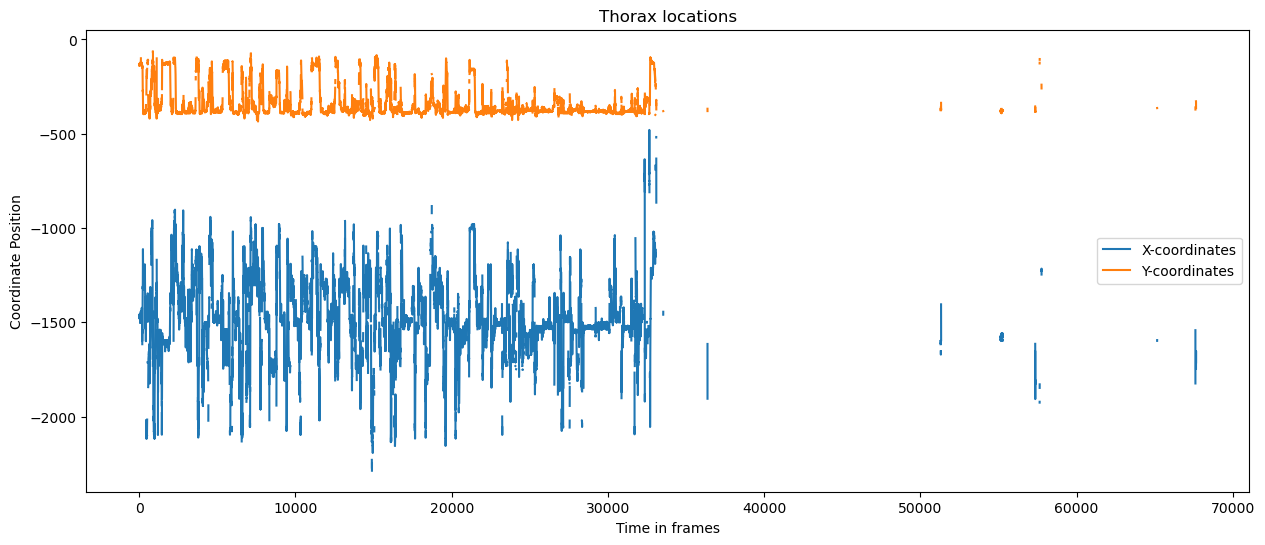

In [60]:
fig, ax = plt.subplots()

plt.plot(thorax_loc[:,0],label='X-coordinates')
# Converting to negative so that we can see both x and y track
plt.plot(-1*thorax_loc[:,1], label='Y-coordinates')

plt.legend(loc="center right")
plt.title('Thorax locations')
plt.xlabel("Time in frames")
plt.ylabel("Coordinate Position")

Text(0, 0.5, 'Y-Coordinates')

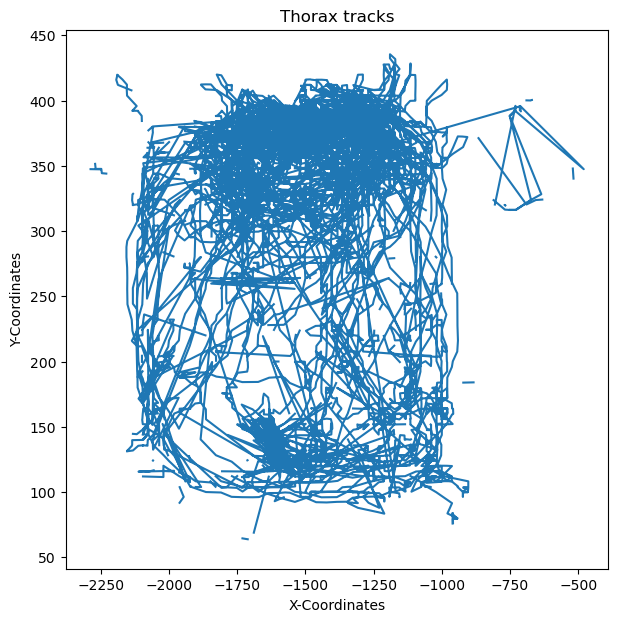

In [61]:
plt.figure(figsize=(7,7))
plt.plot(thorax_loc[:,0],thorax_loc[:,1])


plt.title('Thorax tracks')
plt.xlabel("X-Coordinates")
plt.ylabel("Y-Coordinates")


# Filtering out all the unnecessary pose estimation

- Using the start and stop of each subject to remove all other frames where the subject(s) are not there

In [62]:
raise ValueError("Stop here")

ValueError: Stop here

In [ ]:

# For this example, let's assume we want the slice [:, 1:3], 
# i.e., the last two columns of every row
VIDEO_TO_FRAME_AND_SUBJECT_DF['sliced_locations'] = VIDEO_TO_FRAME_AND_SUBJECT_DF.apply(lambda row: slice_and_zero(row["rescaled_locations"], row["start_frame"], row["stop_frame"]), axis=1)



In [ ]:
VIDEO_TO_FRAME_AND_SUBJECT_DF['sliced_locations'].iloc[0][:5]

In [ ]:
VIDEO_TO_FRAME_AND_SUBJECT_DF['sliced_locations'].iloc[0][-5:]

# Calculating the distance from thorax to reward port

In [ ]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["all_sleap_data"].iloc[0]["node_names"]

In [ ]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["nose_index"] = VIDEO_TO_FRAME_AND_SUBJECT_DF["all_sleap_data"].apply(lambda x: x["node_names"].index("nose"))

In [ ]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["nose_coordinates"] = VIDEO_TO_FRAME_AND_SUBJECT_DF.apply(lambda x: x["sliced_locations"][:,x["nose_index"],:], axis=1)

In [ ]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["nose_coordinates"].head()

In [ ]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["reward_port"]

In [ ]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["nose_to_reward_port_distance"] = VIDEO_TO_FRAME_AND_SUBJECT_DF.apply(lambda row: np.linalg.norm(row["nose_coordinates"] - row["reward_port"], axis=1), axis=1)

In [ ]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["nose_to_reward_port_distance"]

## Combining the pose tracking data with the nose poke entry timestamps

In [ ]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["subject_id"]

In [ ]:
VIDEO_TO_FRAME_AND_SUBJECT_DF.head()

In [ ]:
merged_nose_poke_time_and_sleap = TONE_TIMESTAMP_DF.merge(VIDEO_TO_FRAME_AND_SUBJECT_DF, left_on="video_file", right_on='video_name', how='inner')

- Removing all nose pokes that were not part of the video

In [ ]:
merged_nose_poke_time_and_sleap = merged_nose_poke_time_and_sleap[(merged_nose_poke_time_and_sleap["start_frame"] <= merged_nose_poke_time_and_sleap["video_frame"]) & (merged_nose_poke_time_and_sleap["video_frame"] <= merged_nose_poke_time_and_sleap["stop_frame"])].reset_index(drop=True)

- How to get distance of nose to reward port for each nose poke

In [ ]:
merged_nose_poke_time_and_sleap["nose_poke_distance"] = merged_nose_poke_time_and_sleap.apply(lambda x: x["nose_to_reward_port_distance"][x["video_frame"]], axis=1)

- Filtering by distance that's below a given threshold

In [ ]:
merged_nose_poke_time_and_sleap = merged_nose_poke_time_and_sleap[merged_nose_poke_time_and_sleap["nose_poke_distance"] <= DISTANCE_THRESHOLD]

In [ ]:
merged_nose_poke_time_and_sleap["video_frame"].head(n=10)

In [ ]:
merged_nose_poke_time_and_sleap["subject_id"].head(n=10)

In [ ]:
merged_nose_poke_time_and_sleap["nose_poke_distance"].head(n=10)